### Testing RoBERTa-large-fake-news-detection-spanish with test data in The Spanish Fake News Corpus

In [ ]:
! pip install transformers

In [2]:
from transformers import pipeline, AutoTokenizer, AutoModel
import torch
import pandas as pd
import numpy as np

In [3]:
print(torch.cuda.get_device_name(0))

Tesla K80


Check if gpu is available

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Load roberta fine-tuned with mexican fake news dataset (not directly available unfortunately) https://huggingface.co/Narrativaai/fake-news-detection-spanish

In [8]:
classifier = pipeline("text-classification", model="Narrativaai/fake-news-detection-spanish")

Keep only model and tokenizer

In [9]:
model = classifier.model
tokenizer = classifier.tokenizer
del classifier

model.to(device);

Check gpu memory usage (Around 9 GB). To consider when choosing our model according to available hardware resources

In [4]:
!nvidia-smi

Mon Feb 14 18:00:49 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8    27W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Labels mapping in dataset

In [13]:
id2label = {
    "0": "REAL",
    "1": "FAKE"
}

Load test split in https://github.com/jpposadas/FakeNewsCorpusSpanish shared by Andrés Pitta

In [14]:
test_data = pd.read_excel("test.xlsx")
test_headline = test_data.HEADLINE.tolist()
test_headline = ["" if type(headline) == float else headline for headline in test_headline]
test_text = test_data.TEXT.tolist()
test_label = test_data.CATEGORY.tolist()
test_label = [0 if label else 1 for label in test_label]

Function to generate batches

In [15]:
def get_batches(data, n):
    """Yield successive n-sized batches from list."""
    for i in range(0, len(data), n):
        yield data[i:i + n]

Generate model predictions. Very heavy model, takes about 13 min to generate all predictions and given that model occupies most of gpu batch size must be very low.

In [ ]:
predicted_label = []

for headline, text, label in zip(
        get_batches(test_headline, 2),
        get_batches(test_text, 2),
        get_batches(test_label, 2)
    ):

    input_text_batch = [headline_row + ' [SEP] ' + text_row for headline_row, text_row in zip(headline, text)]
   
    input_tokens = tokenizer(
        input_text_batch,
        max_length=512,
        truncation=True,
        padding=True,
        return_tensors='pt'
    )

    logits = model(**input_tokens.to(device)).logits
    probs = torch.softmax(logits, dim=1)
    predictions = torch.argmax(probs, dim=1).detach().cpu().tolist()
    predicted_label.extend(predictions)

TP, TN, FP, FN rates

In [50]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report
import matplotlib.pyplot as plt

tn, fp, fn, tp = confusion_matrix(test_label, predicted_label).ravel()

print(f"tn: {tn}")
print(f"tp: {tp}")
print(f"fp: {fp}")
print(f"fn: {fn}")

tn: 239
tp: 206
fp: 47
fn: 80


Confusion matrix

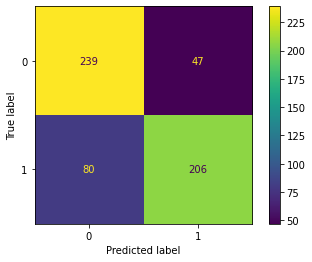

In [42]:
ConfusionMatrixDisplay.from_predictions(test_label, predicted_label)
plt.show()

Classification report

In [51]:
print(classification_report(test_label, predicted_label, target_names=["True", "Fake"]))

              precision    recall  f1-score   support

        True       0.75      0.84      0.79       286
        Fake       0.81      0.72      0.76       286

    accuracy                           0.78       572
   macro avg       0.78      0.78      0.78       572
weighted avg       0.78      0.78      0.78       572

